# <center>Audio Emotion Recognition</center>
## <center>Part 3 - Baseline model</center>
#### <center> 24th August 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
Continuing where we left off in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra), here we'll build a baseline model for an emotion classifier. When I say baseline, I mean its the simplest most parsimonious model I can think of. And view points will vary from one data scientist to another, but essentially its a model __NOT__ meant to achieve full accuracy potential. It's just to qucikly test the framework and setup the blueprint for how we go about creating a workable emotion classifier, cause at the moment, we don't know what works and what doesn't. This is a long notebook so this is the agenda below: 

1. [Data preparation and processing](#data)
    * [Data preparation](#preparation)
    * [Data processing](#processing)
2. [Modelling](#modelling)
3. [Model serialisation](#serialise)
4. [Model validation](#validation)
5. [Final thoughts](#final)

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [1]:
from tensorflow import keras

2022-03-23 18:29:28.306648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/yifan.wang/eccsearch/C:/work/yifan.wang/1-ecc-waveform-PE/IMRPhenomDecc:/work/yifan.wang/lscsoft/opt/accomlal/lib/:/work/yifan.wang/lscsoft/MultiNest/lib:
2022-03-23 18:29:28.306680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

<a id="data"></a>
## 1. Data preparation and processing
We saw in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra) the way we process the audio file into data and the MFCC features we extracted. We're going to do the same thing here except we process the entirity of the audio files. First up we need the reference file that contains the path to the raw audio files for training.

<a id="preparation"></a>
### Data preparation
Lets pick up the meta-data file which we save in [part 1]("https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data"), we're going to need it here to run a loop over it to read all the audio files spread across the 4 directories. 

In [3]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head()

labels source                        path
0     male_happy  SAVEE   ./kaggle-2/ALL/DC_h10.wav
1      male_fear  SAVEE   ./kaggle-2/ALL/KL_f14.wav
2   male_neutral  SAVEE   ./kaggle-2/ALL/KL_n07.wav
3   male_neutral  SAVEE   ./kaggle-2/ALL/JE_n18.wav
4  male_surprise  SAVEE  ./kaggle-2/ALL/JK_su01.wav

So we've already seen the shape of an MFCC output for each file, and it's a 2D matrix of the number of bands by time. In order to optimise space and memory, we're going to read each audio file, extract its mean across all MFCC bands by time, and  just keep the extracted features, dropping the entire audio file data. 

In [4]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


feature
0  [-14.01081, -15.872062, -17.283657, -9.846636,...
1  [-34.365223, -37.193176, -41.796135, -41.67201...
2  [-16.945305, -19.493204, -23.641968, -23.83915...
3  [-8.929358, -13.257127, -25.312065, -24.858978...
4  [-6.317334, -9.478902, -19.40988, -18.62724, -...

<a id="processing"></a>
### Data processing

Like any good standard data science workflow, data processing is the most important step. Cause garbage in grabage out. So lets start munging the data into a workable format and pad out any issues we find. 

In [5]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

labels source                        path          0          1  \
0     male_happy  SAVEE   ./kaggle-2/ALL/DC_h10.wav -14.010810 -15.872062   
1      male_fear  SAVEE   ./kaggle-2/ALL/KL_f14.wav -34.365223 -37.193176   
2   male_neutral  SAVEE   ./kaggle-2/ALL/KL_n07.wav -16.945305 -19.493204   
3   male_neutral  SAVEE   ./kaggle-2/ALL/JE_n18.wav  -8.929358 -13.257127   
4  male_surprise  SAVEE  ./kaggle-2/ALL/JK_su01.wav  -6.317334  -9.478902   

           2          3          4          5          6  ...        206  \
0 -17.283657  -9.846636  -7.066213  -7.329900  -7.425781  ... -20.875538   
1 -41.796135 -41.672016 -42.057243 -36.722324 -31.798765  ... -24.673594   
2 -23.641968 -23.839149 -23.334806 -24.146894 -24.223356  ... -40.210186   
3 -25.312065 -24.858978 -26.600643 -26.726088 -25.850971  ...        NaN   
4 -19.409880 -18.627239 -19.747414 -19.541298 -18.797043  ... -12.635655   

         207        208        209        210        211        212  \
0 -22.639071 -24.623686 -26.172781 -26.662672 -26.128633 -26.520447   
1 -24.244011 -26.617025 -27.416801 -28.629011 -29.346581 -28.693089   
2 -42.988369 -40.496132 -35.968624 -30.394697 -26.159231 -25.761412   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4 -12.566075 -11.622250  -7.692569  -3.889854   0.034570  -1.096090   

         213        214        215  
0 -26.830421 -21.717358 -15.899952  
1 -28.218811 -24.358650 -21.857954  
2 -25.781086 -23.992514 -21.266930  
3        NaN        NaN        NaN  
4  -5.152709  -3.526385  -1.434122  

[5 rows x 219 columns]

In [6]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


labels source                        path          0          1  \
0     male_happy  SAVEE   ./kaggle-2/ALL/DC_h10.wav -14.010810 -15.872062   
1      male_fear  SAVEE   ./kaggle-2/ALL/KL_f14.wav -34.365223 -37.193176   
2   male_neutral  SAVEE   ./kaggle-2/ALL/KL_n07.wav -16.945305 -19.493204   
3   male_neutral  SAVEE   ./kaggle-2/ALL/JE_n18.wav  -8.929358 -13.257127   
4  male_surprise  SAVEE  ./kaggle-2/ALL/JK_su01.wav  -6.317334  -9.478902   

           2          3          4          5          6  ...        206  \
0 -17.283657  -9.846636  -7.066213  -7.329900  -7.425781  ... -20.875538   
1 -41.796135 -41.672016 -42.057243 -36.722324 -31.798765  ... -24.673594   
2 -23.641968 -23.839149 -23.334806 -24.146894 -24.223356  ... -40.210186   
3 -25.312065 -24.858978 -26.600643 -26.726088 -25.850971  ...   0.000000   
4 -19.409880 -18.627239 -19.747414 -19.541298 -18.797043  ... -12.635655   

         207        208        209        210        211        212  \
0 -22.639071 -24.623686 -26.172781 -26.662672 -26.128633 -26.520447   
1 -24.244011 -26.617025 -27.416801 -28.629011 -29.346581 -28.693089   
2 -42.988369 -40.496132 -35.968624 -30.394697 -26.159231 -25.761412   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -12.566075 -11.622250  -7.692569  -3.889854   0.034570  -1.096090   

         213        214        215  
0 -26.830421 -21.717358 -15.899952  
1 -28.218811 -24.358650 -21.857954  
2 -25.781086 -23.992514 -21.266930  
3   0.000000   0.000000   0.000000  
4  -5.152709  -3.526385  -1.434122  

[5 rows x 219 columns]

In [7]:
df.to_csv('./feature.csv')

Now that looks alot better. Next step we will split the data into 2 parts, one for training and one for validation. This ensures we measure the model's performance at its true accuracy. 

In [8]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

0          1          2          3          4          5    \
4950  -17.178810 -17.293514 -18.411484 -18.987421 -17.404621 -16.747271   
3860  -18.445818 -19.675947 -23.553286 -19.885851 -20.420727 -24.015726   
9761   -4.828484  -6.076792  -9.614023 -12.045175  -9.992991 -11.926252   
7620   -7.050759  -4.283337  -4.567834  -5.871509  -5.282473  -6.490458   
11586 -22.590061 -21.799612 -20.563646 -20.703461 -21.205717 -18.608528   
7914  -20.099590 -19.013206 -17.043013 -16.977903 -19.369631 -19.562130   
9513  -20.122581 -18.657488 -16.149492 -16.963455 -18.229979 -18.183958   
5835  -21.096134 -18.702654 -17.710285 -18.043194 -18.252481 -18.710625   
5389  -22.736338 -20.195595 -18.961346 -19.468687 -19.316296 -18.162565   
11222 -20.042538 -17.674582 -19.222475 -18.469973 -17.572329 -17.850544   

             6          7          8          9    ...        206        207  \
4950  -17.733749 -18.055027 -17.931206 -15.913171  ... -22.899403 -21.647814   
3860  -25.965881 -26.209679 -25.481882 -24.306824  ...   0.000000   0.000000   
9761  -14.008464 -13.561556 -14.024567 -15.151946  ...   0.000000   0.000000   
7620   -8.156469  -9.188803  -8.681726  -8.212409  ...   0.000000   0.000000   
11586 -18.446669 -16.211843 -14.257653 -15.160404  ...   0.000000   0.000000   
7914  -22.008749 -20.178379 -17.989597 -19.336285  ...   0.000000   0.000000   
9513  -19.274342 -18.395124 -16.951286 -16.672031  ... -17.882132 -19.390713   
5835  -16.626354 -17.831005 -18.028345 -17.859104  ...   0.000000   0.000000   
5389  -18.102333 -19.914131 -20.931385 -19.215494  ...   0.000000   0.000000   
11222 -17.932026 -20.588900 -18.612183 -15.990725  ... -18.065437 -18.135094   

             208        209        210        211        212        213  \
4950  -19.758650 -18.879402 -19.397377 -20.171659 -22.689241 -24.612816   
3860    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9761    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7620    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11586   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7914    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9513  -17.779472 -19.165937   0.000000   0.000000   0.000000   0.000000   
5835    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5389    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11222 -19.665306 -20.741903 -20.273037 -18.371035 -15.576725 -17.512487   

             214        215  
4950  -24.073122 -23.239702  
3860    0.000000   0.000000  
9761    0.000000   0.000000  
7620    0.000000   0.000000  
11586   0.000000   0.000000  
7914    0.000000   0.000000  
9513    0.000000   0.000000  
5835    0.000000   0.000000  
5389    0.000000   0.000000  
11222 -17.050734 -19.143282  

[10 rows x 216 columns]

Now because we are mixing up a few different data sources, it would be wise to normalise the data. This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, the problem used to be know as "exploding gradients". 

In [9]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

0         1         2         3         4         5         6    \
4950   0.372525  0.350335  0.435090  0.385530  0.495649  0.539844  0.459023   
3860   0.281011  0.174328  0.052892  0.318950  0.272569  0.002023 -0.148844   
9761   1.264568  1.178992  1.089018  0.899999  1.043836  0.896570  0.734101   
7620   1.104057  1.311487  1.464108  1.357512  1.392240  1.298785  1.166216   
11586 -0.018321  0.017438  0.275117  0.258359  0.214509  0.402122  0.406380   
7914   0.161562  0.223289  0.536810  0.534449  0.350311  0.331562  0.143354   
9513   0.159901  0.249569  0.603227  0.535520  0.434604  0.433538  0.345264   
5835   0.089583  0.246232  0.487211  0.455503  0.432939  0.394568  0.540794   
5389  -0.028886  0.135938  0.394218  0.349864  0.354256  0.435121  0.431806   
11222  0.165682  0.322183  0.374808  0.423876  0.483245  0.458209  0.444382   

            7         8         9    ...       206       207       208  \
4950   0.430383  0.433677  0.578932  ... -0.877798 -0.810779 -0.690742   
3860  -0.171003 -0.122837 -0.039411  ...  0.540019  0.526175  0.525864   
9761   0.761765  0.721611  0.635010  ...  0.540019  0.526175  0.525864   
7620   1.084245  1.115399  1.146232  ...  0.540019  0.526175  0.525864   
11586  0.566313  0.704432  0.634387  ...  0.540019  0.526175  0.525864   
7914   0.273791  0.429373  0.326758  ...  0.540019  0.526175  0.525864   
9513   0.405301  0.505901  0.523029  ... -0.567154 -0.671382 -0.568877   
5835   0.446904  0.426517  0.435579  ...  0.540019  0.526175  0.525864   
5389   0.293278  0.212552  0.335657  ...  0.540019  0.526175  0.525864   
11222  0.243516  0.383486  0.573219  ... -0.578503 -0.593836 -0.684994   

            209       210       211       212       213       214       215  
4950  -0.629008 -0.676255 -0.719164 -0.861056 -0.984966 -0.973110 -0.919661  
3860   0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
9761   0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
7620   0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
11586  0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
7914   0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
9513  -0.646546  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
5835   0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
5389   0.526574  0.511818  0.511781  0.512838  0.501315  0.494042  0.486845  
11222 -0.743009 -0.729889 -0.609283 -0.430374 -0.556202 -0.545126 -0.671739  

[10 rows x 216 columns]

For the sake of documentation, I'll just mention here that there's another method for normalisation but it hasn't worked out well, at least not when I implemented it. So I swapped in for something more simple, which is what i've implemented above. Perhaps someone else could give it a try below

```python
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]
```

Next part we'll need to convert the data format to a numpy array, because we are using keras. Initially I had plans to use XGboost or LightGBM for this task. But since I've potential plans to move to a 2D CNN, it may make sense to continue on the Deep Learning path way and implement a ID CNN.

In [10]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


-------------------
Now because we are using a CNN, we need to specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.  

In [11]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

<a id="modelling"></a>
## 2. Modelling
The architecture of the model below is based on a few sources that I've seen before such as Kaggle and Stackoverflow. I'm unable to find the source but safe to say this particular format works quite well and is fast, although I've used GPU. 

In [12]:
from tensorflow.keras import optimizers

In [13]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

2022-03-23 18:42:56.470943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/yifan.wang/eccsearch/C:/work/yifan.wang/1-ecc-waveform-PE/IMRPhenomDecc:/work/yifan.wang/lscsoft/opt/accomlal/lib/:/work/yifan.wang/lscsoft/MultiNest/lib:
2022-03-23 18:42:56.470982: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-23 18:42:56.471032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (condor1): /proc/driver/nvidia/version does not exist
2022-03-23 18:42:56.471449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other oper

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                        

/work/yifan.wang/virtualenv/sgwb/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 46s 78ms/step - loss: 2.4383 - accuracy: 0.1740 - val_loss: 2.4646 - val_accuracy: 0.2197
Epoch 2/100
571/571 [==============================] - 44s 77ms/step - loss: 2.2152 - accuracy: 0.2505 - val_loss: 2.2543 - val_accuracy: 0.2766
Epoch 3/100
571/571 [==============================] - 44s 77ms/step - loss: 2.1025 - accuracy: 0.2839 - val_loss: 2.1841 - val_accuracy: 0.2914
Epoch 4/100
571/571 [==============================] - 43s 76ms/step - loss: 2.0178 - accuracy: 0.3113 - val_loss: 2.1141 - val_accuracy: 0.3140
Epoch 5/100
571/571 [==============================] - 44s 77ms/step - loss: 1.9524 - accuracy: 0.3311 - val_loss: 2.0594 - val_accuracy: 0.3410
Epoch 6/100
571/571 [==============================] - 43s 76ms/step - loss: 1.9048 - accuracy: 0.3500 - val_loss: 2.0134 - val_accuracy: 0.3459
Epoch 7/100
571/571 [==============================] - 44s 77ms/step - loss: 1.8608 - accuracy: 0.3611 - val_loss: 1.9914 - val_ac

571/571 [==============================] - 42s 73ms/step - loss: 1.2316 - accuracy: 0.5789 - val_loss: 1.6341 - val_accuracy: 0.4367
Epoch 58/100
571/571 [==============================] - 42s 73ms/step - loss: 1.2326 - accuracy: 0.5756 - val_loss: 1.6105 - val_accuracy: 0.4360
Epoch 59/100
571/571 [==============================] - 41s 72ms/step - loss: 1.2152 - accuracy: 0.5924 - val_loss: 1.6116 - val_accuracy: 0.4374
Epoch 60/100
571/571 [==============================] - 44s 77ms/step - loss: 1.2080 - accuracy: 0.5880 - val_loss: 1.6077 - val_accuracy: 0.4331
Epoch 61/100
571/571 [==============================] - 45s 79ms/step - loss: 1.1897 - accuracy: 0.6014 - val_loss: 1.6736 - val_accuracy: 0.4150
Epoch 62/100
571/571 [==============================] - 41s 72ms/step - loss: 1.1924 - accuracy: 0.5912 - val_loss: 1.6320 - val_accuracy: 0.4272
Epoch 63/100
571/571 [==============================] - 41s 72ms/step - loss: 1.1814 - accuracy: 0.6009 - val_loss: 1.6107 - val_accuracy

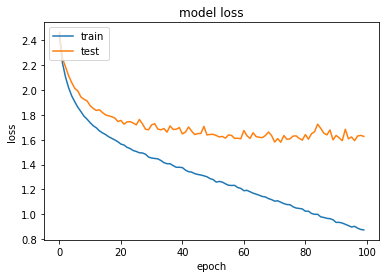

In [15]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we can see that the loss starts to plateau now at around 50 epochs. Regardless we'll keep it at 100 as the final model.

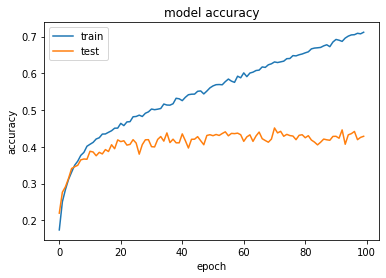

In [16]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<a id="serialise"></a>
## 3. Model serialisation
So its time to serialise the model for re-usability. Serialisation and saving mean the same thing. We need to serialise the model architecture and the weights, thats all. 

In [17]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /work/yifan.wang/machinelearning/happy/saved_models/Emotion_Model.h5 


<a id="validation"></a>
## 4. Model validation
Now predicting emotions on the test data. After serialising the model above, i'm going to just reload it into disk. Essentially to re-use the model without having to retrain by re-running the code, we just need to run this section of the code and apply the model to a new dataset. Since we used the same test set in the keras model, the result is essentially the same as the last epoch of 100 which is 43.80%

In [18]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 42.88%


In [19]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 3s 17ms/step


array([4, 3, 8, ..., 7, 5, 1])

The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure...

In [20]:
preds

array([4, 3, 8, ..., 7, 5, 1])

In [21]:
preds = preds.astype(int).flatten()

In [22]:
preds

array([4, 3, 8, ..., 7, 5, 1])

In [23]:
# predictions 
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

In [24]:
# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
#finaldf[170:180]
#finaldf

In [25]:
finaldf

actualvalues predictedvalues
0     female_disgust  female_neutral
1       female_happy    female_happy
2           male_sad    male_disgust
3         male_angry      male_happy
4         male_happy    female_angry
...              ...             ...
3036      male_happy      male_happy
3037  female_neutral  female_neutral
3038    male_disgust      male_angry
3039    male_neutral      female_sad
3040    female_angry  female_disgust

[3041 rows x 2 columns]

Lets write the predictions out into a file for re-use

In [26]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry              427
female_disgust            430
female_fear               261
female_happy              233
female_neutral            286
female_sad                473
female_surprise           130
male_angry                158
male_disgust              156
male_fear                 143
male_happy                 91
male_neutral              135
male_sad                   87
male_surprise              31

So, we've made our predictions, so how well have we done? We're going to use the most simplest form of accuracy measure which is absolute accuracy, which is really just the % of records where Actual = Predicted, over the total number of records predicted. We'll also produce the F1, recall and precision scores. 

The most common way to visualise this output is via a confusion matrix. I found an excellent heat map plot to visualise the accuracy of the confusion matrix [here](https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823) which i've borrowed for this notebook

In [27]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


#### Emotion by gender accuracy  
So lets visualise how well we have done for the Emotion by Gender model

0.42880631371259453


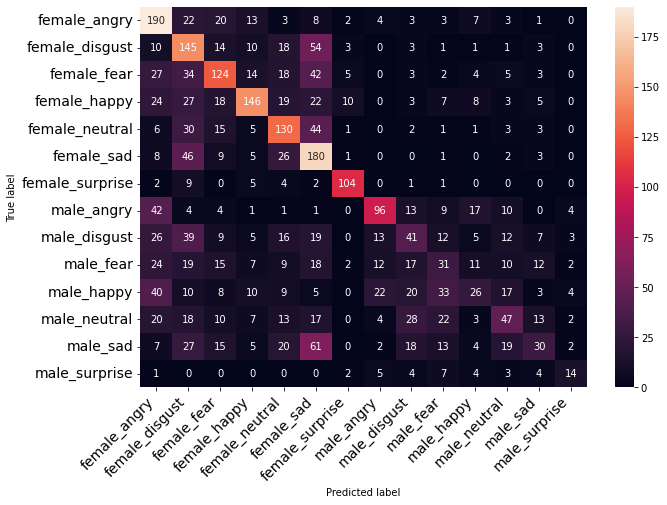

In [28]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [29]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.44      0.68      0.54       279
 female_disgust       0.34      0.55      0.42       263
    female_fear       0.48      0.44      0.46       281
   female_happy       0.63      0.50      0.56       292
 female_neutral       0.45      0.54      0.49       241
     female_sad       0.38      0.64      0.48       281
female_surprise       0.80      0.81      0.81       128
     male_angry       0.61      0.48      0.53       202
   male_disgust       0.26      0.20      0.23       207
      male_fear       0.22      0.16      0.19       189
     male_happy       0.29      0.13      0.17       207
   male_neutral       0.35      0.23      0.28       204
       male_sad       0.34      0.13      0.19       223
  male_surprise       0.45      0.32      0.37        44

       accuracy                           0.43      3041
      macro avg       0.43      0.42      0.41      3041
   weighted avg       0.43   

Absolute accuracy for the gender by emotions is 43%. Whilst that may not seem high at first but remember, a random guess correct is 1 out of 14 which is 7%. So 43% is huge! The heat map plot below will do justice in illustrating how good the results is. And note we have only just scratched the surface

---------------
#### Gender accuracy result 
if you notice, that the gender classification is more accurate. So lets group them up and measure the accuracy again?

0.7839526471555409


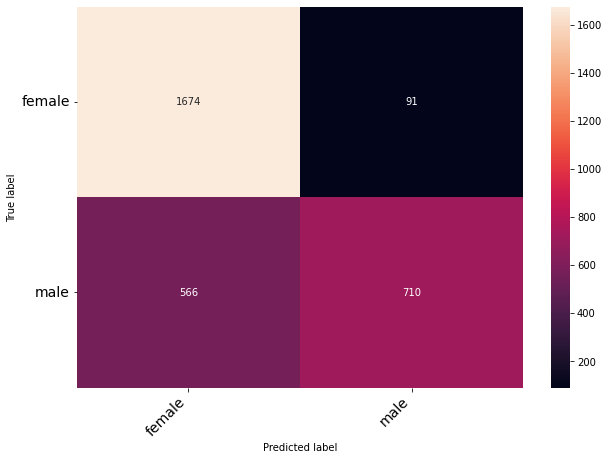

In [30]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [31]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.75      0.95      0.84      1765
        male       0.89      0.56      0.68      1276

    accuracy                           0.78      3041
   macro avg       0.82      0.75      0.76      3041
weighted avg       0.81      0.78      0.77      3041



With just gender we get a 80% accuracy. The model is especially precise in capturing female voices. However, male voices tends to be harder and it does make higher mistakes thinking its female. 

#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.4962183492272279


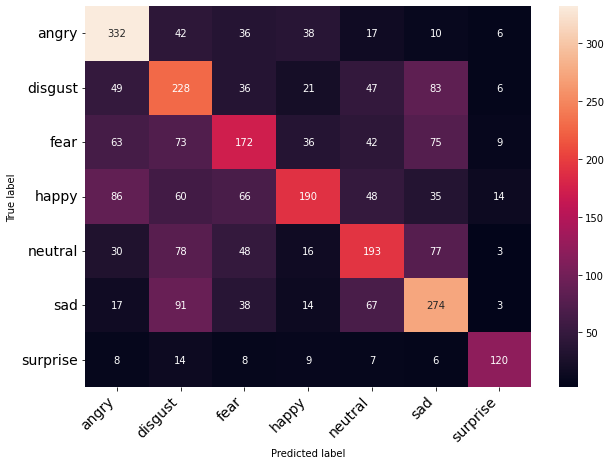

In [32]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [33]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.57      0.69      0.62       481
     disgust       0.39      0.49      0.43       470
        fear       0.43      0.37      0.39       470
       happy       0.59      0.38      0.46       499
     neutral       0.46      0.43      0.45       445
         sad       0.49      0.54      0.52       504
    surprise       0.75      0.70      0.72       172

    accuracy                           0.50      3041
   macro avg       0.52      0.51      0.51      3041
weighted avg       0.50      0.50      0.49      3041



50%, not too shabby indeed. The precision and recall for 'Surprise' and 'Angry' is pretty good in particular 

<a id="final"></a>
## 5. Final thoughts 
The gender seperation turns out to be a curcial implementation in order to accurately classify emotions. Upon closer inspection of the confusion matrix, it seems that female tends to express emotions in a more, obvious manner, for the lack of a better word. Whilst males tend to be very placid or subtle. This is probably why we see the error rate amongst males are really high. For example, male happy and angry gets mixed up quite often. 

In our next section we will be checking for generalisability of this initial baseline solution before  before implementing further enhancements, followed by an audio streamer that will give us the capability of predicting the emotions of a segment of the audio call.  

This section of the notebook borrowed heavily from this [repository](https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer). The original author may have overstated the accuracy as I wasn't able to replicate the accuracy results but, by in large the approach is pretty sound and I've taken his work as a blueprint to setup my own here. 